In [1]:
import json
import yaml
from typing import Dict

from openai import OpenAI

from config import get_settings
from utils.schema_model_maker import SchemaModelMaker

settings = get_settings()

In [2]:
client = OpenAI(
    base_url=settings.VLM_BASE_URL,
    api_key=settings.VLM_API_KEY
)
print(settings.VLM_MODEL)

Qwen3-VL-32B-Instruct-FP8


# Load Prompt, Schema

In [3]:
TASK="example"

In [4]:
def load_prompt(name):
    with open(f"prompts/{TASK}.yaml", "r") as f:
        prompt = yaml.load(f, Loader=yaml.FullLoader)
    return prompt
    
prompt = load_prompt(TASK)
prompt

{'order': ['system', 'user1'],
 'role': ['system', 'user'],
 'system': {'text': '주어진 문서에서 "테이블" (표) 영역들을 모두 추출하도록 합니다\n\n다음 JSON 형식으로 반환하세요\n{{\n  "items": [\n    {{\n        "item_bbox": {{\n            "x1": int,\n            "y1": int,\n            "x2": int,\n            "y2": int,\n        }},\n        "item_description": "표를 html로 작성한 텍스트",\n    }},\n    ...\n  ]\n}}'},
 'user1': {'text': 'Page', 'image_url': '{page_image_url}'}}

# Prepare Messages

In [5]:
# example image from qwen3-vl repo
image_url = "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/179729.jpg"

In [13]:
def make_messages(prompt, input_variables: Dict[str, str]):
    messages = []
    for order, role in zip(prompt["order"], prompt["role"]):
        content_params = prompt[order]
        
        contents = []
        contents.append(
            {
                "type": "text",
                "text": content_params["text"].format(**input_variables)
            }
        )
        if "image_url" in content_params:
            contents.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": content_params["image_url"].format(**input_variables)
                    }
                }
            )
        message = {
            "role": role,
            "content": contents
        }
        messages.append(message)
    return messages

In [14]:
input_variables = {
    "page_image_url": image_url
}
messages = make_messages(prompt, input_variables=input_variables)

In [15]:
print(json.dumps(messages, indent=2, ensure_ascii=False))

[
  {
    "role": "system",
    "content": [
      {
        "type": "text",
        "text": "주어진 문서에서 \"테이블\" (표) 영역들을 모두 추출하도록 합니다\n\n다음 JSON 형식으로 반환하세요\n{\n  \"items\": [\n    {\n        \"item_bbox\": {\n            \"x1\": int,\n            \"y1\": int,\n            \"x2\": int,\n            \"y2\": int,\n        },\n        \"item_description\": \"표를 html로 작성한 텍스트\",\n    },\n    ...\n  ]\n}"
      }
    ]
  },
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": "Page"
      },
      {
        "type": "image_url",
        "image_url": {
          "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/179729.jpg"
        }
      }
    ]
  }
]


# Prepare ResponseFormat

In [16]:
def load_response_format(name):
    with open(f"schemas/{name}.json", "r") as f:
        specification = json.load(f)
    response_format = SchemaModelMaker.make(
        specification=specification["main"],
        item_specifications=specification["items"]
    )
    return response_format

In [17]:
response_format = load_response_format(TASK)

# Call Chat Completion

In [18]:
def generate(messages, response_format):
    response = client.chat.completions.parse(
        messages=messages,
        model=settings.VLM_MODEL,
        temperature=0.2,
        response_format=response_format,
    )
    return response.choices[0].message.parsed

In [19]:
result = generate(messages, response_format)

In [20]:
print(json.dumps(result.model_dump(), indent=2, ensure_ascii=False))

{
  "items": [
    {
      "item_bbox": {
        "x1": 106,
        "y1": 275,
        "x2": 387,
        "y2": 448
      },
      "item_description": "<table><tr><th>行业</th><td>汽车和汽车零部件</td></tr><tr><th>公司网址</th><td>www.yutong.com</td></tr><tr><th>大股东/持股</th><td>宇通集团/37.19%</td></tr><tr><th>总股本(百万股)</th><td>2,214</td></tr><tr><th>总通 A 股(百万股)</th><td>1,903</td></tr><tr><th>流通 B/H 股(百万股)</th><td>0</td></tr><tr><th>总市值 ( 亿元 )</th><td>488.39</td></tr><tr><th>流通 A 股市值(亿元)</th><td>419.91</td></tr><tr><th>每股净资产(元)</th><td>6.28</td></tr><tr><th>资产负债率(%)</th><td>52.30</td></tr></table>"
    },
    {
      "item_bbox": {
        "x1": 409,
        "y1": 764,
        "x2": 935,
        "y2": 931
      },
      "item_description": "<table><tr><th></th><th>2015A</th><th>2016A</th><th>2017E</th><th>2018E</th><th>2019E</th></tr><tr><td>营业收入(百万元)</td><td>31211</td><td>35,850</td><td>38,715</td><td>43,226</td><td>46,108</td></tr><tr><td>YoY(%)</td><td>21.3</td><td>14.9</td><td>8.0</td><td>11.7</td><t

# Visualize

In [21]:
import requests
from io import BytesIO

from PIL import Image
from utils.image_utils import crop_image

In [22]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [23]:
bbox = result.items[0].item_bbox.model_dump()
print(bbox)

{'x1': 106, 'y1': 275, 'x2': 387, 'y2': 448}


In [24]:
cropped_img = crop_image(img, bbox)

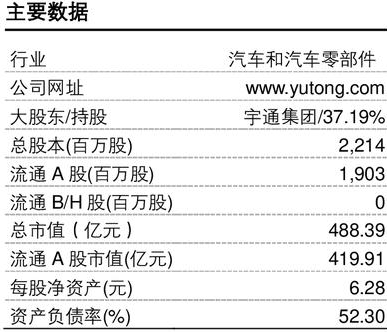

In [25]:
cropped_img